In [1]:
from tensorflow.keras import backend as K
K.clear_session()

import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import random
import numpy as np
from matplotlib import pyplot as plt

from tifffile import imread

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import minmax_scale
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from sklearn.model_selection import train_test_split

In [3]:
from configparser import ConfigParser

try:
    from google.colab import files
    
    print('upload `config.ini`')
    uploaded = files.upload()
except:
    print('no colab detected -> reading from local disk')

config = ConfigParser()
config.read('config.ini')

upload `config.ini`


Saving config.ini to config.ini


['config.ini']

In [4]:
import os
from pathlib import Path

try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = Path(config.get('data folder', 'colab'))
except:
  import os
  from pathlib import Path
  here = Path(os.getcwd())
  data_path = here / config.get('data folder', 'taurus')

print('getting data from {}, folders there are: {}'.format(data_path, list(os.walk(data_path))[0][1]))

Mounted at /content/gdrive
getting data from /content/gdrive/My Drive/Colab Notebooks/martin/fluo, folders there are: ['masks', 'images', '.ipynb_checkpoints', 'aug']


In [16]:
image_shape = (config.getint('image', 'width'), config.getint('image', 'height'))
input_shape = (*image_shape, config.getint('image', 'depth'))
output_shape = (388, 388, config.getint('image', 'depth'))

input shape is (572, 572, 1)


In [17]:
def crop_center(crop_shape):
    (width, height) = crop_shape

    def get_start_point(dim, cropping):
        return dim // 2 - cropping // 2
    
    def get_end_point(start, cropping):
        return start + cropping
    
    def _f(img):
        (y, x) = img.shape
        (start_x, start_y) = (get_start_point(x, width), get_start_point(y, height))
        (end_x, end_y) = (get_end_point(start_x, width), get_end_point(start_y, height))
        
        return img[start_y : end_y, start_x : end_x]
    
    return _f


def get_data(imgs_path, masks_path, image_shape):    
    def load_tiff(f, crop_shape, normalize):
        img = imread(f)
        img = crop_center(crop_shape)(img)
        if normalize:
            img = minmax_scale(img.ravel()).reshape(image_shape)

        return img
    
    def load_image(name):
        f = imgs_path / name
        return load_tiff(f, image_shape, True)
    
    def load_mask(name):
        name = name.replace('img_', 'mask_')
        f = masks_path / name
        return load_tiff(f, (388, 388), False)

    list_imgs = next(os.walk(imgs_path))[2]

    X = np.zeros((len(list_imgs), *image_shape), dtype=np.float32)
    y = np.zeros((len(list_imgs), *(388, 388)), dtype=np.float32)
    
    for i, img_name in enumerate(list_imgs):
        X[i] = load_image(img_name).squeeze()
        y[i] = load_mask(img_name)

    return X, y

X, y = get_data(
    data_path / config.get('data folder', 'images'),
    data_path / config.get('data folder', 'masks'),
    image_shape
)
X = X.reshape(len(X), *input_shape)  # keras wants 3D images even if gray scale
y = y.reshape(len(y), *output_shape)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config.getfloat('experiment', 'test size'))
print('found {} samples: {} training, {} validation'.format(len(X), len(X_train), len(X_valid)))

found 92 samples: 82 training, 10 validation


24

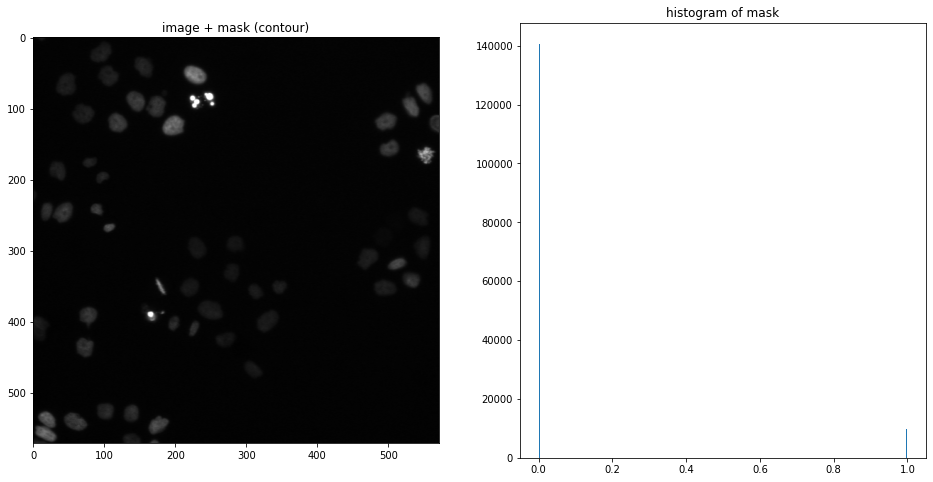

In [21]:
def plot_train_sample(X, y, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('image + mask (contour)')

    ax[1].hist(y[ix].ravel(), bins=256)
    ax[1].set_title('histogram of mask')
        
    return ix

def plot_pred_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('image + mask (contour)')

    ax[1].imshow(preds[ix].squeeze(), cmap='gray')
    ax[1].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    ax[1].set_title('predicted + original mask (contour)')

    return ix

def plot_results(results):
    plt.figure(figsize=(16, 8))

    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")

    plt.xlabel("epochs")
    plt.ylabel("log loss")
    plt.legend()

plot_train_sample(X_train, y_train)  # check if training data looks all right

In [24]:
def conv2d_block(n_filters, kernel_shape, dropout=0.0, batchnorm=True):
  activation = 'relu'

  def _f(x):
    n_layers = 2

    for _ in range(n_layers):
      x = Conv2D(n_filters, kernel_shape, padding='valid')(x)
      
      if batchnorm:
        x = BatchNormalization()(x)
      
      x = Activation(activation=activation)(x)

      if dropout > 0:
        x = Dropout(dropout)(x)

    return x

  return _f


def contracting_block(n_filters, kernel_shape, pool_shape, dropout, batchnorm):
  pooling = MaxPooling2D(pool_shape)

  def _f(x):
    x = conv2d_block(n_filters, kernel_shape, dropout, batchnorm)(x)
    skip_conn = x  # save for expanding path
    x = pooling(x)  # ready for next block
    
    return x, skip_conn

  return _f


def contracting_path(n_filters, n_layers, kernel_shape, pool_shape, dropout, batchnorm):
  def _f(x):
    skip_conns = []
    current_n_filters = n_filters

    for _ in range(n_layers):
      x, s = contracting_block(current_n_filters, kernel_shape, pool_shape, dropout, batchnorm)(x)
    
      current_n_filters *= 2
      skip_conns.append(s)

    return x, skip_conns

  return _f


def middle_path(kernel_shape, dropout, batchnorm):
  def _f(x):
    n_filters = x.shape[-1] * 2
    x = conv2d_block(n_filters, kernel_shape, dropout, batchnorm)(x)
    return x

  return _f

from tensorflow.keras.layers.experimental.preprocessing import CenterCrop

def expanding_block(n_filters, skip_conn, kernel_shape, pool_shape, dropout, batchnorm):
  upsampling = UpSampling2D(pool_shape)

  def _f(x):
    x = upsampling(x)
    s = CenterCrop(x.shape[1], x.shape[2])(skip_conn)
    
    x = concatenate([x, s])
    x = conv2d_block(n_filters, kernel_shape, dropout, batchnorm)(x)
    return x

  return _f


def expanding_path(skip_conns, kernel_shape, pool_shape, dropout, batchnorm):
  def _f(x):
    current_n_filters = skip_conns[-1].shape[-1]

    for skip_conn in reversed(skip_conns):
      x = expanding_block(current_n_filters, skip_conn, kernel_shape, pool_shape, dropout, batchnorm)(x)
      current_n_filters /= 2

    return x

  return _f


def final_path(n_classes, activation):
  def _f(x):
    x = Conv2D(n_classes, (1, 1), padding='valid', activation=activation)(x)
    return x

  return _f


def get_unet(input_img, n_filters, n_layers, kernel_size, pool_size, n_classes, final_activation, dropout=0.0, batchnorm=False):
  n_dim = 2 if input_img.shape[-1] == 1 else 3
  kernel_shape = (kernel_size, ) * n_dim
  pool_shape = (pool_size, ) * n_dim

  x, skip_conns = contracting_path(n_filters, n_layers, kernel_shape, pool_shape, dropout, batchnorm)(input_img)
  x = middle_path(kernel_shape, dropout, batchnorm)(x)
  x = expanding_path(skip_conns, kernel_shape, pool_shape, dropout, batchnorm)(x)
  outputs = final_path(n_classes, final_activation)(x)

  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [25]:
model = get_unet(
  Input(input_shape),
  config.getint('unet', 'n filters'),
  config.getint('unet', 'n layers'),
  3,
  2,
  1,
  config.get('unet', 'final activation'),
  config.getfloat('unet', 'dropout'),
  config.getboolean('unet', 'batchnorm')
)
# model.summary()

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.4113 - accuracy: 0.9527 - mean_io_u_4: 0.4763
Epoch 00001: loss improved from inf to 0.41128, saving model to bestModel.h5
21/21 [==============================] - 23s 1s/step - loss: 0.4113 - accuracy: 0.9527 - mean_io_u_4: 0.4763 - val_loss: 0.2296 - val_accuracy: 0.9487 - val_mean_io_u_4: 0.4743
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.9600 - mean_io_u_4: 0.4763
Epoch 00002: loss improved from 0.41128 to 0.12979, saving model to bestModel.h5
21/21 [==============================] - 18s 851ms/step - loss: 0.1298 - accuracy: 0.9600 - mean_io_u_4: 0.4763 - val_loss: 0.0654 - val_accuracy: 0.9792 - val_mean_io_u_4: 0.4743
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9731 - mean_io_u_4: 0.4772
Epoch 00003: loss did not improve from 0.12979
21/21 [==============================] - 17s 824ms/step - loss: 0.1387 - accuracy: 0.9731 

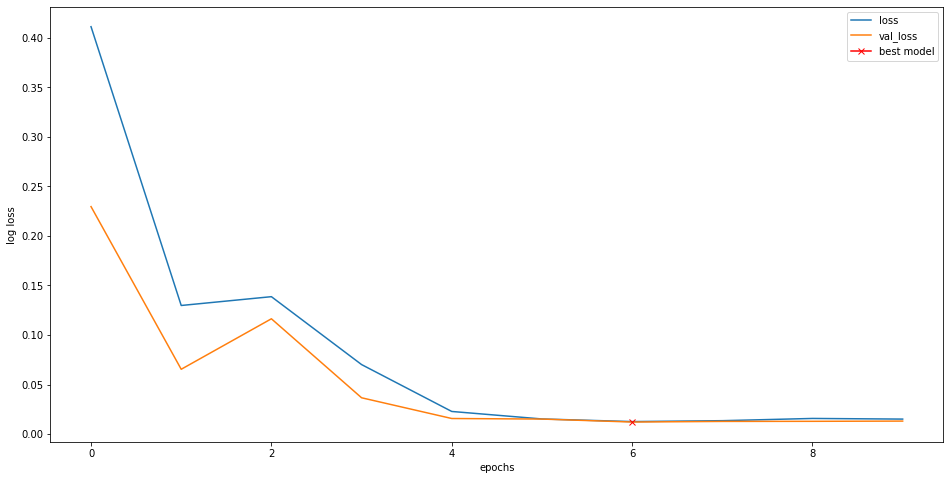

In [28]:
verbose = config.getint('experiment', 'verbose')
best_model_weights = config.get('experiment', 'weights file')
training_batch_size = config.getint('training', 'batch size')
epochs = 10  # config.getint('training', 'epochs')

callbacks = [
    EarlyStopping(patience=10, verbose=verbose),
    ReduceLROnPlateau(factor=1e-1, patience=3, min_lr=1e-5, verbose=verbose),
    ModelCheckpoint(best_model_weights, monitor='loss', verbose=verbose, save_best_only=True, save_weights_only=True)
]

model.compile(
    optimizer=config.get('training', 'optimizer'),
    loss=config.get('training', 'loss'),
    metrics=['accuracy', MeanIoU(num_classes=2)]
)
results = model.fit(X_train, y_train, batch_size=training_batch_size, epochs=epochs, callbacks=callbacks, validation_data=(X_valid, y_valid))
plot_results(results)

model.load_weights(best_model_weights)
preds_val = model.predict(X_valid, verbose=verbose)

1

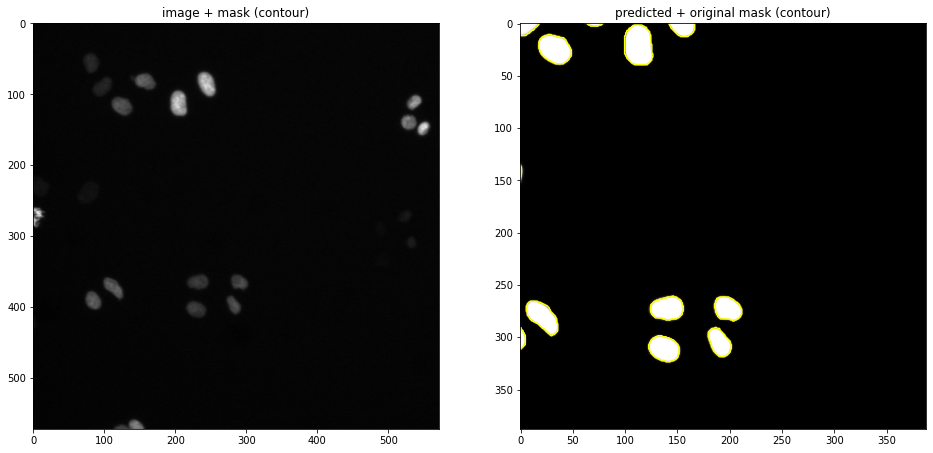

In [29]:
plot_pred_sample(X_valid, y_valid, preds_val)  # predictions on test data